Note - The data has been imported from seesee's upload. Thank You seesee. Since this is medical data this data was and will not be downloaded locally. We have also joined the google group but had trouble with importing the data by using GCP and other tools. Thank You.

# <div style=' background-color: #ddffff; border-left: 10px solid #2196F3; padding: 20px;'> Playing with the data! </div>

### <div style=' color: white; background-color: #2D93D5; border-left: 10px solid #014F99; padding: 20px;'> Problem Understood ? - Nope! </div>
- The problem is divided into 2 sub-problems -
    - Identifying if there is a lung diesease.
    - If there is a lung diesease then try to identify the reigon of effect and try to create a mask out of it.
    - The above 2 are the main ones and then the 3rd step is to encode the mask as a binary image and then use the given functions (mask_functions.py) to return a RLE (Run Length Encoded String).


### <div style=' color: white; background-color: #2D93D5; border-left: 10px solid #014F99; padding: 20px;'>Importing Libraries</div>
- <i> Numpy, pandas, pydicom, matplotlib</i>

In [12]:
import numpy as np
import pandas as pd 
import pydicom
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2

Error File: train-rle-sample.csv

 Sample File looks like: 

[[ 78  81  81 ... 222 228 234]
 [ 71  71  71 ... 220 223 226]
 [ 61  59  59 ... 219 219 220]
 ...
 [ 17  17  17 ... 208 209 208]
 [ 17  18  18 ... 208 209 209]
 [ 18  19  19 ... 209 210 210]]


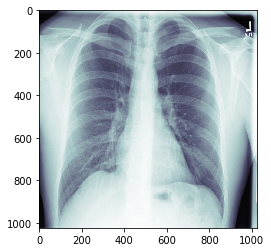

In [13]:
#Checking for errorneous files
base_pth = "../input/siim-acr-pneumothorax-segmentation/sample images/"
for each in (os.listdir("../input/siim-acr-pneumothorax-segmentation/sample images")):
    try:
        ds = pydicom.dcmread(base_pth + each)
    except:
        print("Error File: "+each)

#Reading and displaying a sample image

print("\n Sample File looks like: \n")
ds = pydicom.dcmread("../input/siim-acr-pneumothorax-segmentation/sample images/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm")
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 
print(ds.pixel_array)

### <div style=' color: white; background-color: #2D93D5; border-left: 10px solid #014F99; padding: 20px;'>Some Observations</div>

#### Sample Dataset
- From above observation we've found out that all the images are of dimensions 1024x1024 and are in a special format dicom. 
- Total 11 files in sample set.

#### Obvious Stuff - Training and Test Datasets -
- Training Set Size - 10712 - The training dataset is in the format of 10712 studies and each contains exactly 1 series and in it exactly 1 image/instance.
- Testing Set Size - 1377 - The test dataset is also in similar format with 1377 studies and each contains 1 series and 1 image/instance.

### <div style=' color: white; background-color: #2D93D5; border-left: 10px solid #014F99; padding: 20px;'>Creating DataFrame</div>
- <i> Getting image grid (1024 x 1024) reshaping and transforming into features (1048576) and the encoded pixels from csv files to 0 and 1 (binary) labels, where -1 will be 0 and all other will be 1 (indicating the lung has diesease). </i>

In [74]:
#Prepping X_train
#Note - 256 x 256 - 2.6 GB, 512 x 512 - 4.5 GB
    
X_train = []

for filename in Path('../input/siim-train-test/siim/dicom-images-train/').glob('**/*.dcm'):
    ds = pydicom.dcmread(str(filename))
    b0 = cv2.resize(ds.pixel_array,(512,512))
    b = np.reshape(b0,-1)
    X_train.append(b)

In [75]:
#Prepping Y_train
import re

df_train = pd.read_csv('../input/siim-train-test/siim/train-rle.csv')
y_train = []

for filename in Path('../input/siim-train-test/siim/dicom-images-train/').glob('**/*.dcm'):
    tmp = re.search('/[0-9.]*[.]*[0-9]*.dcm',str(filename))
    idz = str(tmp.group()[1:-4])
    
    for idx,each in enumerate(df_train['ImageId']):
        if each == idz:
            if (df_train.iloc[idx,1] == ' -1'):
                y_train.append(0)
            else:
                y_train.append(1)
        else:
            continue